In [125]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from scipy.signal import butter, filtfilt
import os
from detecta import detect_onset, detect_peaks
from player_information import player_information
import math
from Functions import Joint_Angle

def butter_lowpass_filtfilt(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low')
    y = filtfilt(b, a, data)
    return y

def calculate_angle(a, b):
    dot_product = a[0]*b[0] + a[1]*b[1]
    magnitude_a = math.sqrt(a[0]**2 + a[1]**2)
    magnitude_b = math.sqrt(b[0]**2 + b[1]**2)
    
    # 안전한 acos 계산을 위한 값 클램핑
    cos_angle = max(min(dot_product / (magnitude_a * magnitude_b), 1), -1)
    angle_radians = math.acos(cos_angle)
    angle_degrees = math.degrees(angle_radians)

    # 방향성 결정을 위한 '외적' 계산
    cross_product = a[0]*b[1] - a[1]*b[0]
    
    # 음수이면 360도에서 각도를 빼서 방향성 반영
    if cross_product < 0:
        angle_degrees = 360 - angle_degrees

    return angle_degrees

player_height, player_weight, player_kor_name, player_birth = player_information()

In [126]:
day = '20240325'
DIR = glob(f'Data/{day}/*.csv')[:1]
DIR

['Data/20240325/uplift_data_export_20240325080326.csv']

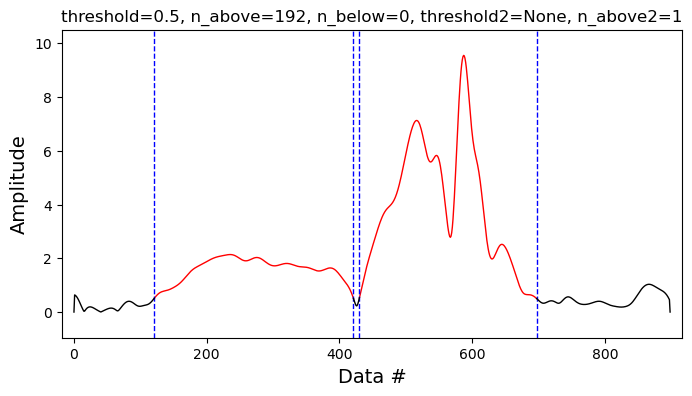

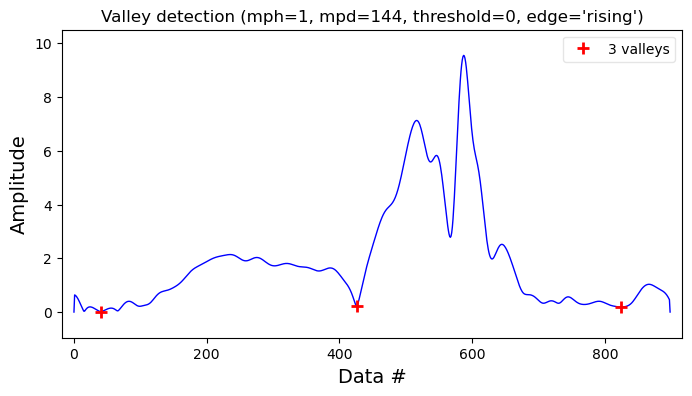

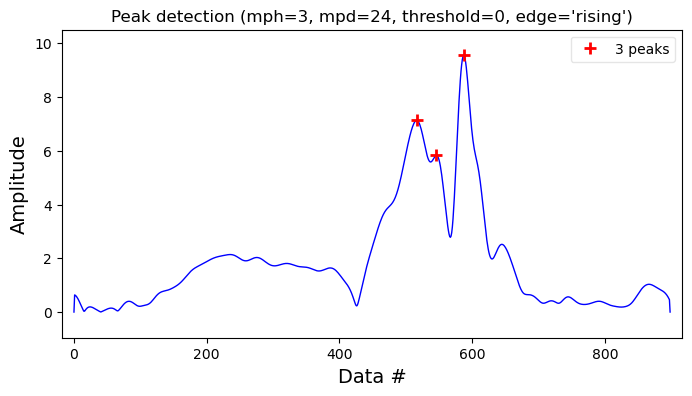

121 426 531 697


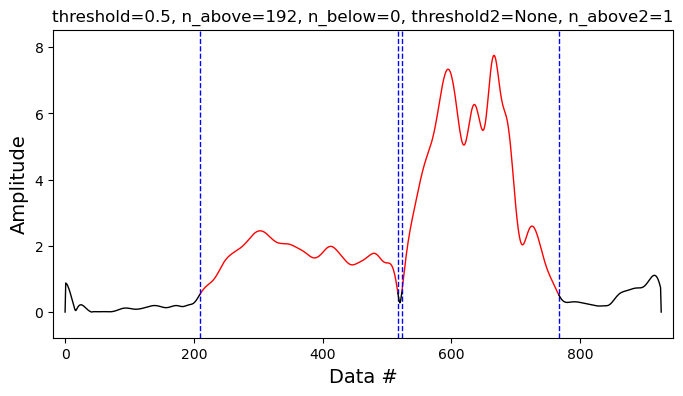

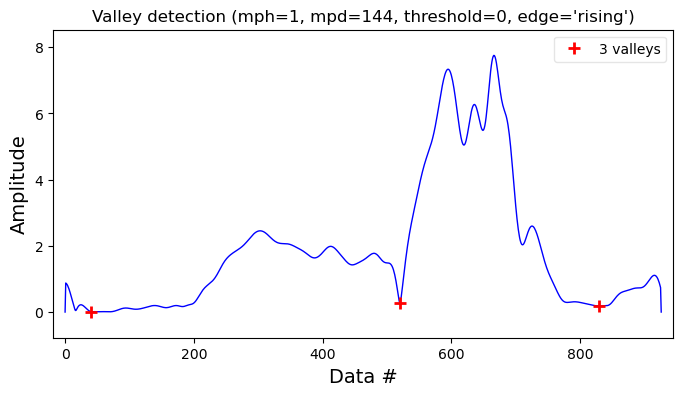

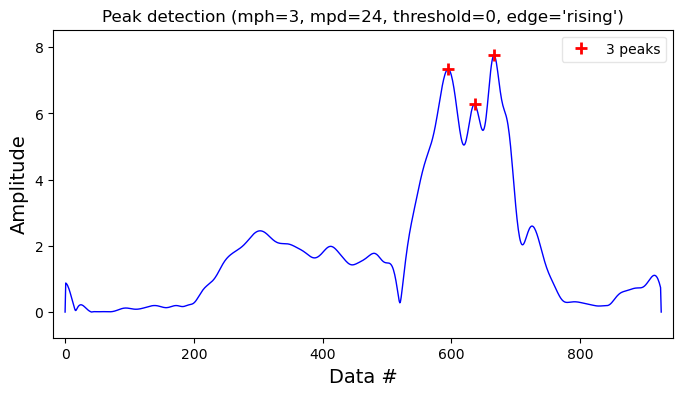

209 520 610 767


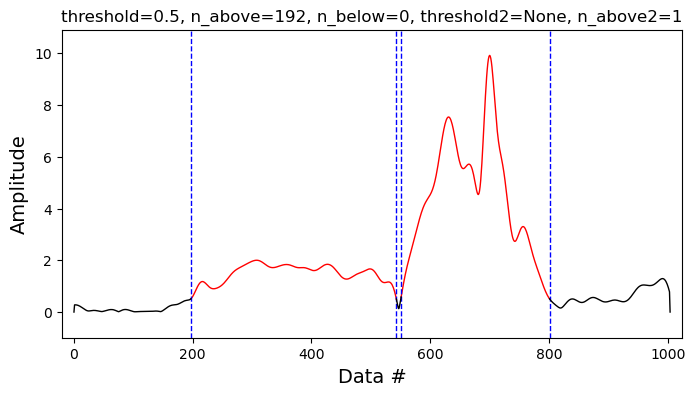

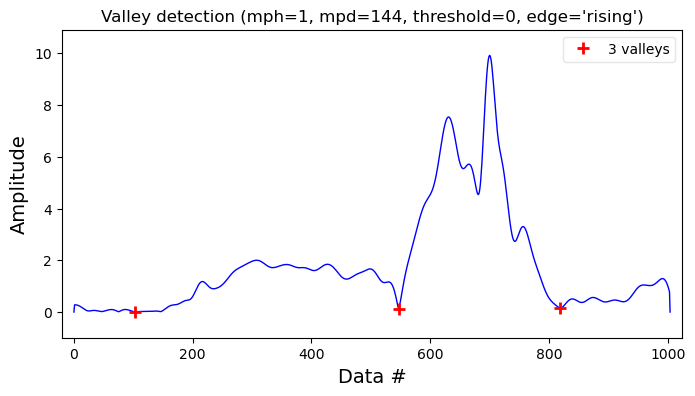

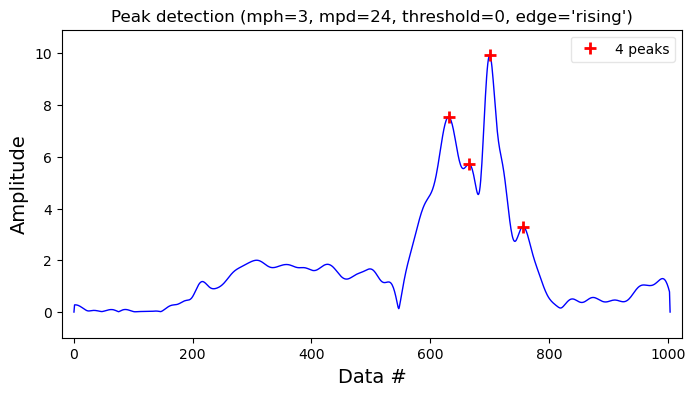

197 547 646 801


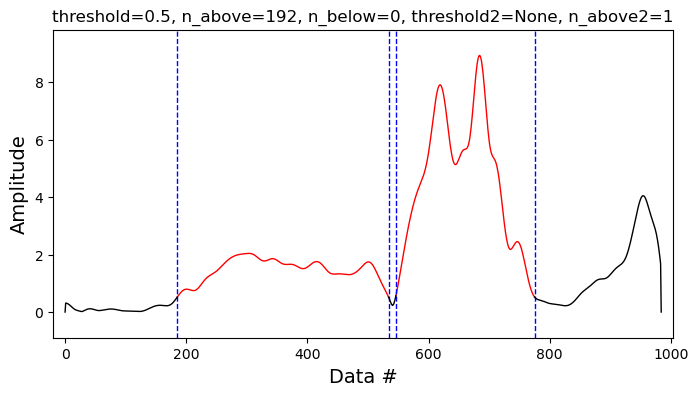

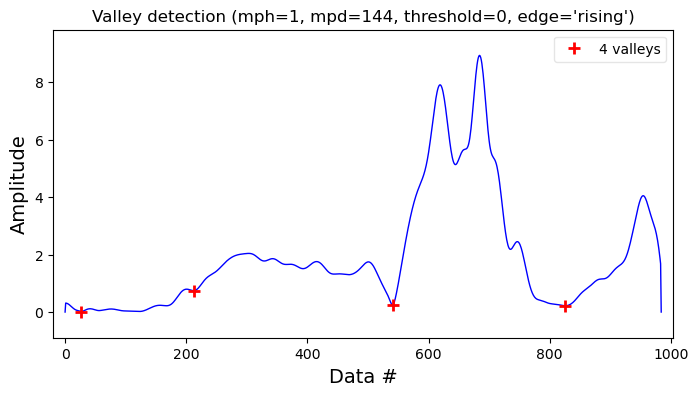

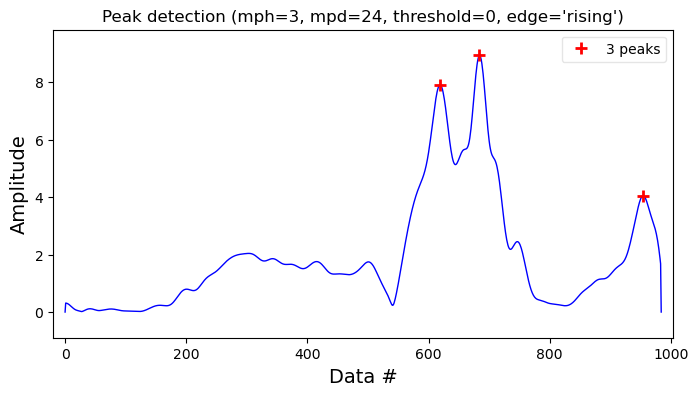

185 541 634 775


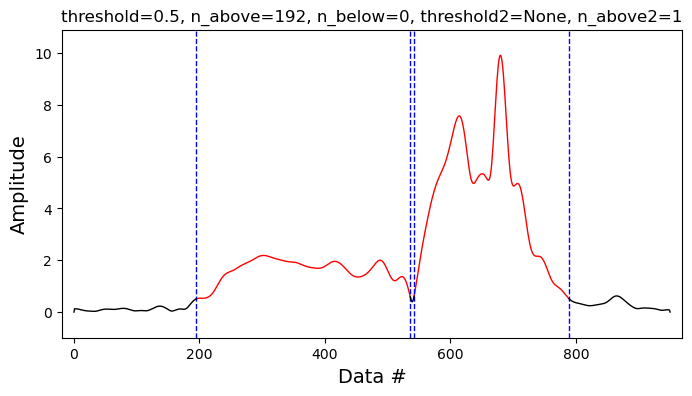

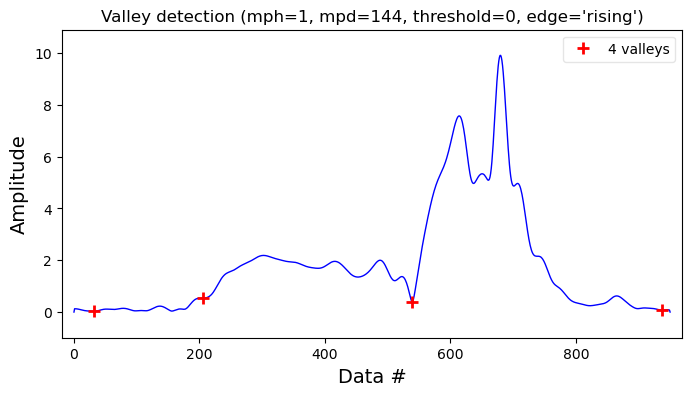

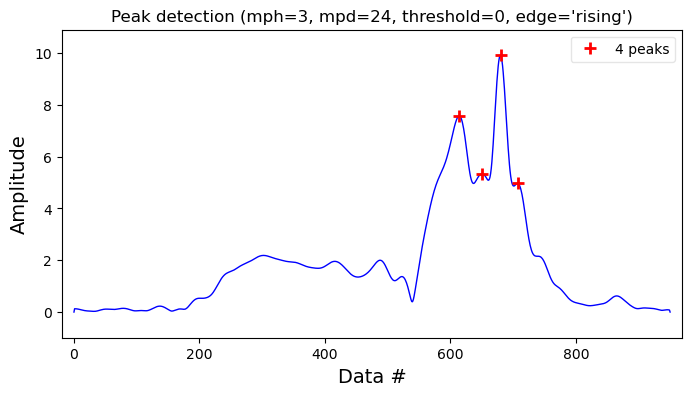

195 539 629 789


In [127]:
sr = 240
dt = 1/sr
plot = True

FALSE_DF  = {}
for dir in DIR:
    df = pd.read_csv(dir)
    for session in df.sessionid.unique():
        d = df[df['sessionid'] == session].reset_index(drop=True)
        session_num = session.split('_')[-1]
        name = d['athlete_name'].values[0]
        height = player_height[name]
        weight = player_weight[name]
        
        os.makedirs(f"Data/{day}/processing", exist_ok=True)
        os.makedirs(f"Data/{day}/processing/{name}",exist_ok=True)
        handedness = d['handedness'].values[0]
        y_jc_offset = d['left_ankle_jc_3d_y'].min()
        jc_y_cols = []
        for c in d.columns:
            if '3d_y' in c:
                jc_y_cols.append(c)
        d[jc_y_cols]  = d[jc_y_cols] - y_jc_offset
        wrist_jc = d[['left_wrist_jc_3d_x','left_wrist_jc_3d_y','left_wrist_jc_3d_z']].copy()
        for c in wrist_jc.columns:
            wrist_jc[c] = butter_lowpass_filtfilt(wrist_jc[c], 6, sr, 2)
        
        wrist_jc_vel = (wrist_jc - wrist_jc.shift(2)).shift(-1)/dt
        wrist_jc_vel_sum = np.sqrt(np.sum(wrist_jc_vel**2, axis=1))
        
        
        left_hip_jc = d[['left_hip_jc_3d_x','left_hip_jc_3d_y','left_hip_jc_3d_z']].copy()
        right_hip_jc = d[['right_hip_jc_3d_x','right_hip_jc_3d_y','right_hip_jc_3d_z']].copy()
        left_sho_jc = d[['left_shoulder_jc_3d_x','left_shoulder_jc_3d_y','left_shoulder_jc_3d_z']].copy()
        right_sho_jc = d[['right_shoulder_jc_3d_x','right_shoulder_jc_3d_y','right_shoulder_jc_3d_z']].copy()
        
        hip_jc_distance = np.sqrt( (left_hip_jc.iloc[:,0]-right_hip_jc.iloc[:,0])**2 + (left_hip_jc.iloc[:,1]-right_hip_jc.iloc[:,1])**2 + (left_hip_jc.iloc[:,2]-right_hip_jc.iloc[:,2])**2 )
        hip_jc_height = left_hip_jc.iloc[:,1] - right_hip_jc.iloc[:,1]
        pelvic_tilt = np.rad2deg(np.arcsin(hip_jc_height.copy(),hip_jc_distance.copy()))
        sho_jc_distance = np.sqrt( (left_sho_jc.iloc[:,0]-right_sho_jc.iloc[:,0])**2 + (left_sho_jc.iloc[:,1]-right_sho_jc.iloc[:,1])**2 + (left_sho_jc.iloc[:,2]-right_sho_jc.iloc[:,2])**2 )
        sho_jc_height = left_sho_jc.iloc[:,1] - right_sho_jc.iloc[:,1]
        trunk_tilt = np.rad2deg(np.arcsin(sho_jc_height.copy(),sho_jc_distance.copy()))
        
        hip_vec = right_hip_jc.iloc[:,[0,2]].values - left_hip_jc.iloc[:,[0,2]].values
        trunk_vec = right_sho_jc.iloc[:,[0,2]].values - left_sho_jc.iloc[:,[0,2]].values
        ref = np.array([1,0])

        N = hip_vec.shape[0]
        pel_rot = np.zeros(N)
        trk_rot = np.zeros(N)


        for i in range(N):
            h_v = hip_vec[i,:]
            t_v = trunk_vec[i,:]
            pel_rot[i] = calculate_angle(ref, h_v)
            trk_rot[i] = calculate_angle(ref, t_v)

        pel_rot = - Joint_Angle.process_angle(pd.Series(pel_rot, name = 'Pelvic Rotation')) + 90
        trk_rot = - Joint_Angle.process_angle(pd.Series(trk_rot, name = 'Trunk Rotation')) + 90

        try:
            timing = detect_onset(wrist_jc_vel_sum, threshold=0.5, n_above = sr * 0.8, show=plot)
            address = timing[0][0]
            top = [i for i in detect_peaks(wrist_jc_vel_sum, mph=1, mpd=sr*0.6, show=plot,valley=True) if address + 60 < i][0]
            finish = timing[-1][-1]
            impact = [i for i in detect_peaks(wrist_jc_vel_sum, mph=3, mpd=sr*0.1, show=plot) if top < i][0] + 15
            
            if address < top < impact < finish:
                d['trunk_lateral_tilt'] = trunk_tilt
                d['trunk_rotation'] = trk_rot
                d['pelvic_lateral_tilt'] = pelvic_tilt
                d['pelvic_rotation'] = pel_rot
                d['address'] = address
                d['top'] = top
                d['impact'] = impact
                d['finish'] = finish
                d['height'] = height
                d['weight'] = weight
                print(address, top, impact, finish)
                d = d.reset_index(drop=True)
                d.to_csv(f"Data/{day}/processing/{name}/{name}_{int(session_num):03d}.csv", index =False)
            
            else:
                FALSE_DF[name_trial] = d
                print(f"{name}_{int(session_num):03d} : 시점 오류") 
                

        except Exception as e:
            print(f"{name}_{int(session_num):03d} : {e}")
            name_trial = f"{name}_{int(session_num):03d}"
            FALSE_DF[name_trial] = d

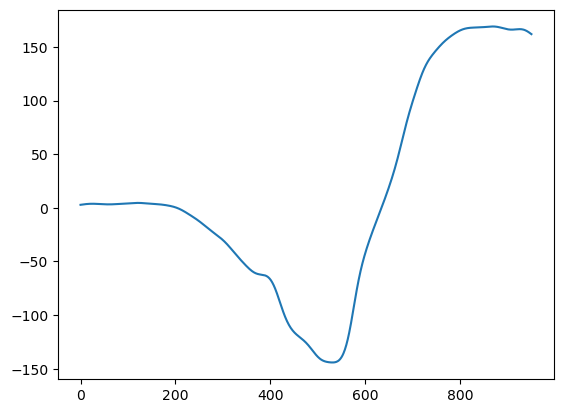

In [128]:
plt.plot(trk_rot)

In [9]:
# import sys
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython import display
# from Functions import Animated
# from Functions import Joint_Angle

# speed = 1
# name = ''
# axis = 'y'
# jc_cols = []
# for c in d.columns:
#     if '3d' in c:
#         jc_cols.append(c) 
# markers = {}
# mrk_df = d[jc_cols].copy()
# for i in range(0,len(mrk_df.columns), 3):
#     markers[mrk_df.columns[i].replace('_x','')] = mrk_df.iloc[:,i:i+3].T.values

# connections = [
#     ('pelvis_3d','left_hip_jc_3d'),('pelvis_3d','right_hip_jc_3d'),
#     ('proximal_neck_3d', 'right_shoulder_jc_3d'),('proximal_neck_3d', 'left_shoulder_jc_3d'),
#     ('pelvis_3d','proximal_neck_3d'),
#     ('left_knee_jc_3d','left_hip_jc_3d'),
#     ('left_ankle_jc_3d','left_knee_jc_3d'),
#     ('right_knee_jc_3d','right_hip_jc_3d'),
#     ('right_ankle_jc_3d','right_knee_jc_3d'),
#     ('left_elbow_jc_3d','left_shoulder_jc_3d'),
#     ('right_elbow_jc_3d','right_shoulder_jc_3d'),
#     ('left_elbow_jc_3d','left_wrist_jc_3d'),
#     ('right_elbow_jc_3d','right_wrist_jc_3d'),
# ]

# anim = Animated.Animate_3d(markers,speed,90,axis,name,240,connections)
# video = anim.to_html5_video()
# html = display.HTML(video)
# display.display(html)
# plt.close()

In [11]:
# import sys
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation
# from IPython import display
# from Functions import Animated
# from Functions import Joint_Angle

# speed = 1
# name = ''
# axis = 'z'
# jc_cols = []
# for c in d.columns:
#     if '3d' in c:
#         jc_cols.append(c) 
# markers = {}
# mrk_df = d[jc_cols].copy()
# for i in range(0,len(mrk_df.columns), 3):
#     markers[mrk_df.columns[i].replace('_x','')] = mrk_df.iloc[:,i:i+3].T.values

# connections = [
#     ('pelvis_3d','left_hip_jc_3d'),('pelvis_3d','right_hip_jc_3d'),
#     ('proximal_neck_3d', 'right_shoulder_jc_3d'),('proximal_neck_3d', 'left_shoulder_jc_3d'),
#     ('pelvis_3d','proximal_neck_3d'),
#     ('left_knee_jc_3d','left_hip_jc_3d'),
#     ('left_ankle_jc_3d','left_knee_jc_3d'),
#     ('right_knee_jc_3d','right_hip_jc_3d'),
#     ('right_ankle_jc_3d','right_knee_jc_3d'),
#     ('left_elbow_jc_3d','left_shoulder_jc_3d'),
#     ('right_elbow_jc_3d','right_shoulder_jc_3d'),
#     ('left_elbow_jc_3d','left_wrist_jc_3d'),
#     ('right_elbow_jc_3d','right_wrist_jc_3d'),
# ]

# anim = Animated.Animate_3d(markers,speed,90,axis,name,240,connections)
# video = anim.to_html5_video()
# html = display.HTML(video)
# display.display(html)
# plt.close()

In [43]:
# def Trunk(LSJC, RSJC, NECK):
#     origin = NECK
#     y = LSJC-RSJC
#     z_temp = NECK-RSJC
#     x = np.cross(y, z_temp)
#     z = np.cross(x, y)
    
#     x_norm = x/np.linalg.norm(x)
#     y_norm = y/np.linalg.norm(y)
#     z_norm = z/np.linalg.norm(z)
    
#     R = np.transpose(np.array([x_norm,y_norm,z_norm]))
    
#     return R




# LSJC = markers['left_shoulder_jc_3d']
# NECK = markers['pelvis_3d']
# RSJC = markers['right_shoulder_jc_3d']

# LHJC = markers['left_hip_jc_3d']
# PELV = markers['pelvis_3d']
# RHJC = markers['right_hip_jc_3d']

# N = markers['left_shoulder_jc_3d'].shape[-1]
# trunk_R = np.zeros((3,3,N))
# pelvis_R = np.zeros((3,3,N))

# for i in range(N):
#     z = LSJC[:,i]-RSJC[:,i]
#     y_temp = NECK[:,i]-RSJC[:,i]
#     x = np.cross(z, y_temp)
#     y = np.cross(x, z)
    
#     x_norm = x/np.linalg.norm(x)
#     y_norm = y/np.linalg.norm(y)
#     z_norm = z/np.linalg.norm(z)
    
#     R = np.transpose(np.array([x_norm,z_norm,y_norm]))
#     trunk_R[:,:,i] = R
    
#     z = LHJC[:,i]-RHJC[:,i]
#     y_temp = PELV[:,i]-RHJC[:,i]
#     x = np.cross(z, y_temp)
#     y = np.cross(x, z)
    
#     x_norm = x/np.linalg.norm(x)
#     y_norm = y/np.linalg.norm(y)
#     z_norm = z/np.linalg.norm(z)
    
#     R = np.transpose(np.array([x_norm,z_norm,y_norm]))
#     pelvis_R[:,:,i] = R